# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors 
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

### Importing necessary libraries

In [1]:
import numpy as np
import os
import h5py
import torch 
import torch.nn as nn
from tqdm import trange
import matplotlib.pyplot as plt
from torch.autograd import grad, Variable
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1234)

current_workspace = os.getcwd()
device = 'cpu'
dtype = torch.float32

### Creating and importing the data

In [2]:
def get_data(nc=1000):
    with h5py.File('Datasets/LinearElasticity1d_inverse.h5', 'r') as file:
        x_obs = np.array(file['x_obs']).reshape(-1,1) 
        u_obs = np.array(file['u_obs']).reshape(-1,1)
        
        x_test = np.array(file['x_test']).reshape(-1,1)
        e_test = np.array(file['e_test']).reshape(-1,1)
        u_test = np.array(file['u_test']).reshape(-1,1)

    # For training
    x_obs = torch.tensor(x_obs, dtype=dtype)
    u_obs = torch.tensor(u_obs, dtype=dtype)

    # For testing the performance
    x_test = torch.tensor(x_test, dtype=dtype)
    e_test = torch.tensor(e_test, dtype=dtype)
    u_test = torch.tensor(u_test, dtype=dtype)

    # The collocations points
    lb, ub = np.array([0.]), np.array([1.])
    x_in = np.random.uniform(lb, ub, nc)
    x_in = torch.tensor(x_in, dtype=dtype)

    return x_obs, u_obs, x_test, e_test, u_test, x_in

def show_data_info():
    x_obs, u_obs, x_test, e_test, u_test, x_in = get_data()
    
    # Printing the size of the data
    print('The shape of x_obs:', x_obs.shape)
    print('The shape of u_obs:', u_obs.shape)
    print('The shape of x_test:', x_test.shape)
    print('The shape of e_test:', e_test.shape)
    print('The shape of u_test:', u_test.shape)
    print('The shape of x_in:', x_in.shape)

    # Showing the observed data for training
    plt.figure()
    plt.scatter(x_obs, u_obs, label='u_obs')
    plt.title('The observation')
    plt.legend()
    plt.show()


Defining the Dataset Class for loading the data

In [3]:
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x.reshape(-1, 1)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

### Building the architecture of the NN

In [4]:
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x
        
    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return torch.nn.functional.silu(x)

### Defining the loss class of the PINN

In [5]:
class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
            return torch.sin(torch.pi * x) * u

class LossClass(object):

    def __init__(self, u_model, e_model):
        self.device = device
        self.u_model = u_model 
        self.e_model = e_model
        self.getLoss = torch.nn.MSELoss()
        #
        self.mollifier = Mollifier(1)
    
    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        #
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ex = self.e_model(x)
        #
        s = ex * du_dx
        ds_dx = grad(inputs=x, outputs=s, grad_outputs=torch.ones_like(s), create_graph=True)[0]

        # f(x)
        f = 9.81

        # The residuals
        residual = - ds_dx - f
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss

    def loss_data(self, x_obs, u_obs):
        '''loss term corresponds to the observation'''
        x = x_obs.to(self.device)
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)
        #
        loss = self.getLoss(u, u_obs.to(self.device))
        
        return loss

    def loss_e_boundary(self):
        '''loss term to impose the known values of the elastic modulous in the boundary'''
        x_bc = torch.tensor([[0.0], [1.0]], dtype=torch.float32).to(self.device)
        e_bc = torch.tensor([[1.0], [1.0]], dtype=torch.float32).to(self.device)
        e_pred = self.e_model(x_bc)
        return self.getLoss(e_pred, e_bc)
    
    def get_error_u(self, x_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.mollifier.apply(u, x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))
        
    def get_error_e(self, x_test, e_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        e_test = e_test.to(self.device)
        e = self.e_model(x_test)
        
        return torch.sqrt(torch.sum((e-e_test)**2)/torch.sum(e_test**2))


### Builfding the training function

In [6]:
def train_inverse_PINN(hiperparams):
    '''Trains a PINN to solve the inverse problem'''

    x_obs, u_obs, x_test, e_test, u_test, x_in = get_data(hiperparams['nc'])
    dataloader = DataLoader(MyDataset(x_in), batch_size=hiperparams['batch_size'], shuffle=True)
    model_u = MLP(hiperparams['u_layers'], dtype=torch.float32).to(device)
    model_e = MLP(hiperparams['e_layers'], dtype=torch.float32).to(device)
    optimizer = torch.optim.Adam(params=list(model_u.parameters())+list(model_e.parameters()), lr=hiperparams['lr'], weight_decay=hiperparams['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(hiperparams['epochs']/hiperparams['scheduler_step']), gamma=hiperparams['gamma'])
        
    loss_list, error_u_list, error_e_list = [],  [], []
    for epoch in trange(hiperparams['epochs']):
        loss = 0.
        for x_batch in dataloader:
            lossClass = LossClass(model_u, model_e)
            ############# Calculate losses
            loss_pde = lossClass.loss_pde(x_batch)
            loss_data = lossClass.loss_data(x_obs, u_obs)
            loss_e_bc = lossClass.loss_e_boundary()

            loss_train = hiperparams['w_pde'] * loss_pde + hiperparams['w_data'] * loss_data + hiperparams['w_bc_e'] * loss_e_bc
            #
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            loss += loss_train

        # save loss
        loss = loss/len(dataloader)
        loss_list.append(loss.item())
        
        # compute error
        with torch.no_grad():
            error_u = lossClass.get_error_u(x_test, u_test)
            error_u_list.append(error_u.item())
            error_e = lossClass.get_error_e(x_test, e_test)
            error_e_list.append(error_e.item())

        # Adjust learning rate
        scheduler.step() 

        # Print results loss and l2 error in epoch 
        if (epoch+1)%25==0:
            print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
            print(error_u_list.pop(), error_e_list.pop())
        
    os.makedirs('Models', exist_ok=True)
    torch.save(model_u.state_dict(), f"Models/best_model_A_inverse_u.pth")
    torch.save(model_e.state_dict(), f"Models/best_model_A_inverse_e.pth")
    return loss_list, error_u_list, error_e_list

In [7]:
def plot_results(nc, model_u, model_e, loss_list=None, error_u_list=None, error_e_list=None, save=False):
    if save:
        os.makedirs('Results', exist_ok=True)
        os.makedirs('Results/Problem_A_task2', exist_ok=True)

    _, _, x_test, e_test, u_test, _ = get_data(nc)

    # The prediction
    u_pred = model_u(x_test.to(device)).detach()
    u_pred = Mollifier(1).apply(u_pred, x_test)
    e_pred = model_e(x_test.to(device)).detach()

    error_u = torch.sqrt(torch.sum((u_test-u_pred)**2)/torch.sum(u_test**2))
    error_e = torch.sqrt(torch.sum((e_test-e_pred)**2)/torch.sum(e_test**2))
    print(f'The l2 error of model u is: {error_u}')
    print(f'The l2 error of model e is: {error_e}')

    # The loss evolution 
    if loss_list:
        plt.figure(figsize=(6, 4))
        plt.semilogy(loss_list)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Evolution of the training loss')
        if save: plt.savefig(f'Results/Problem_A_task2/loss.png') 
        plt.show()

    # The u l2 error evolution
    if error_u_list:
        plt.figure(figsize=(6, 4))
        plt.semilogy(error_u_list, label='$L^2$ relative error (E)')
        plt.title('$L^2$ relative error vs. epochs for u')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        if save: plt.savefig(f'Results/Problem_A_task2/l2_U.png') 
        plt.show()
    
    # The e l2 error evolution
    if error_e_list:
        plt.figure(figsize=(6, 4))
        plt.semilogy(error_e_list, label='$L^2$ relative error (E)')
        plt.title('$L^2$ relative error vs. epochs for E')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        if save: plt.savefig(f'Results/Problem_A_task2/l2_E.png') 
        plt.show()
    
    ### U PlOTS ######################################

    # Plot u true
    plt.figure(figsize=(6, 4))
    plt.plot(x_test.numpy().squeeze(), u_test.numpy().squeeze(), linewidth=2, color='darkblue')
    plt.title('U true')
    plt.xlabel('x')
    plt.ylabel('u')
    if save: plt.savefig(f'Results/Problem_A_task2/U_true.png') 
    plt.show()
    
    # Plot u Pred
    plt.figure(figsize=(6, 4))
    plt.plot(x_test.numpy().squeeze(), u_pred.numpy().squeeze(), linewidth=2, color='black')
    plt.title('U Pred')
    plt.xlabel('x')
    plt.ylabel('u')
    if save: plt.savefig(f'Results/Problem_A_task2/U_Pred.png') 
    plt.show()

    # Plot pointwise abs error
    plt.figure(figsize=(6, 4))
    plt.plot(x_test, np.abs(u_pred.numpy().squeeze() - u_test.numpy().squeeze()), linewidth=2, color='red')
    plt.title('Absolute Pointwise Error (u)')
    plt.xlabel('x')
    plt.ylabel('|u_true - u_pred|')
    if save: plt.savefig(f'Results/Problem_A_task2/U_pointwise_error.png') 
    plt.show()

    ### E PlOTS ######################################

  # Plot E true
    plt.figure(figsize=(6, 4))
    plt.plot(x_test.numpy().squeeze(), e_test.numpy().squeeze(), linewidth=2, color='darkblue')
    plt.title('E true')
    plt.xlabel('x')
    plt.ylabel('E')
    if save: plt.savefig(f'Results/Problem_A_task2/E_true.png') 
    plt.show()
    
    # Plot E Pred
    plt.figure(figsize=(6, 4))
    plt.plot(x_test.numpy().squeeze(), e_pred.numpy().squeeze(), linewidth=2, color='black')
    plt.title('E Pred')
    plt.xlabel('x')
    plt.ylabel('E')
    if save: plt.savefig(f'Results/Problem_A_task2/E_Pred.png') 
    plt.show()

    # Plot pointwise abs error
    plt.figure(figsize=(6, 4))
    plt.plot(x_test, np.abs(e_pred.numpy().squeeze() - e_test.numpy().squeeze()), linewidth=2, color='red')
    plt.title('Absolute Pointwise Error (u)')
    plt.xlabel('x')
    plt.ylabel('|E_true - E_pred|')
    if save: plt.savefig(f'Results/Problem_A_task2/E_pointwise_error.png') 
    plt.show()

### Solving the problem

#### Plotting the data

The shape of x_obs: torch.Size([250, 1])
The shape of u_obs: torch.Size([250, 1])
The shape of x_test: torch.Size([1001, 1])
The shape of e_test: torch.Size([1001, 1])
The shape of u_test: torch.Size([1001, 1])
The shape of x_in: torch.Size([1000])


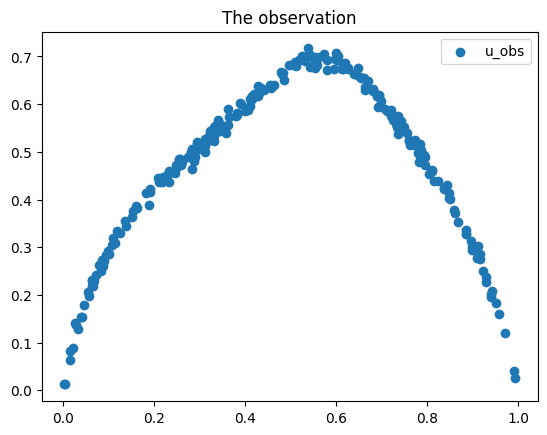

In [8]:
show_data_info()

#### Training the PINN for the inverse problem

In [9]:
hiperparams = {'nc':200000, 'batch_size':1000, 'lr':3e-3, 
                   'epochs': 800, 'u_layers':[1, 40, 40, 40, 40, 1], 'e_layers':[1, 40, 40, 40, 40, 1],
                   'w_pde':2., 'w_data':200., 'w_bc_e':100., 'scheduler_step':8, 'weight_decay':1e-4, 'gamma':0.5}

In [10]:
loss_list, error_u_list, error_e_list = train_inverse_PINN(hiperparams)

  3%|▎         | 25/800 [01:00<30:26,  2.36s/it]

Epoch:24, The loss is:0.19451983273029327, lr: 0.003
0.056576747447252274 0.41845816373825073


  6%|▋         | 50/800 [02:19<1:08:07,  5.45s/it]

Epoch:49, The loss is:2.0581037998199463, lr: 0.003
0.07449958473443985 0.3530508875846863


  9%|▉         | 75/800 [03:48<42:42,  3.53s/it]  

Epoch:74, The loss is:4.136421203613281, lr: 0.003
0.02876434288918972 0.24138790369033813


 12%|█▎        | 100/800 [05:16<38:49,  3.33s/it]

Epoch:99, The loss is:0.10810081660747528, lr: 0.0015
0.04031537473201752 0.3170173764228821


 16%|█▌        | 125/800 [06:47<41:08,  3.66s/it]

Epoch:124, The loss is:0.02474774233996868, lr: 0.0015
0.010949461720883846 0.11639679968357086


 19%|█▉        | 150/800 [08:15<37:56,  3.50s/it]

Epoch:149, The loss is:0.026467856019735336, lr: 0.0015
0.010909020900726318 0.10193336009979248


 22%|██▏       | 175/800 [09:39<35:36,  3.42s/it]

Epoch:174, The loss is:0.17244288325309753, lr: 0.0015
0.008145315572619438 0.0900067687034607


 25%|██▌       | 200/800 [11:01<30:06,  3.01s/it]

Epoch:199, The loss is:0.02536408044397831, lr: 0.00075
0.007979408837854862 0.08458297699689865


 28%|██▊       | 225/800 [12:20<29:25,  3.07s/it]

Epoch:224, The loss is:0.02035258710384369, lr: 0.00075
0.006435673218220472 0.06509792059659958


 31%|███▏      | 250/800 [13:35<27:20,  2.98s/it]

Epoch:249, The loss is:0.0359630361199379, lr: 0.00075
0.00649631954729557 0.059745337814092636


 34%|███▍      | 275/800 [14:50<26:31,  3.03s/it]

Epoch:274, The loss is:0.020375382155179977, lr: 0.00075
0.0067355274222791195 0.06361022591590881


 38%|███▊      | 300/800 [16:08<26:05,  3.13s/it]

Epoch:299, The loss is:0.022398492321372032, lr: 0.000375
0.00552736409008503 0.05422712117433548


 41%|████      | 325/800 [17:21<23:27,  2.96s/it]

Epoch:324, The loss is:0.02010698802769184, lr: 0.000375
0.004639260936528444 0.043756064027547836


 44%|████▍     | 350/800 [18:35<22:18,  2.97s/it]

Epoch:349, The loss is:0.019280312582850456, lr: 0.000375
0.004523559007793665 0.04108813405036926


 47%|████▋     | 375/800 [19:52<21:45,  3.07s/it]

Epoch:374, The loss is:0.019212286919355392, lr: 0.000375
0.004408420063555241 0.03975865617394447


 50%|█████     | 400/800 [21:08<19:52,  2.98s/it]

Epoch:399, The loss is:0.20362941920757294, lr: 0.0001875
0.006916132289916277 0.03914542496204376


 53%|█████▎    | 425/800 [22:24<20:33,  3.29s/it]

Epoch:424, The loss is:0.022735999897122383, lr: 0.0001875
0.004118702374398708 0.0362280011177063


 56%|█████▋    | 450/800 [23:41<17:41,  3.03s/it]

Epoch:449, The loss is:0.019279010593891144, lr: 0.0001875
0.0040793148800730705 0.03463933244347572


 59%|█████▉    | 475/800 [24:57<16:46,  3.10s/it]

Epoch:474, The loss is:0.01901954598724842, lr: 0.0001875
0.00414832029491663 0.034557607024908066


 62%|██████▎   | 500/800 [26:15<15:52,  3.18s/it]

Epoch:499, The loss is:0.02061283029615879, lr: 9.375e-05
0.004057673271745443 0.03479519858956337


 66%|██████▌   | 525/800 [27:33<14:27,  3.16s/it]

Epoch:524, The loss is:0.01897333562374115, lr: 9.375e-05
0.004056283738464117 0.03306460380554199


 69%|██████▉   | 550/800 [28:52<12:59,  3.12s/it]

Epoch:549, The loss is:0.01904734969139099, lr: 9.375e-05
0.0041252318769693375 0.03297415375709534


 72%|███████▏  | 575/800 [30:11<11:08,  2.97s/it]

Epoch:574, The loss is:0.018926749005913734, lr: 9.375e-05
0.004015480633825064 0.03255600854754448


 75%|███████▌  | 600/800 [31:31<10:52,  3.26s/it]

Epoch:599, The loss is:0.018922092393040657, lr: 4.6875e-05
0.00403031287714839 0.032565679401159286


 78%|███████▊  | 625/800 [32:53<09:12,  3.16s/it]

Epoch:624, The loss is:0.01888657920062542, lr: 4.6875e-05
0.004004953429102898 0.032361868768930435


 81%|████████▏ | 650/800 [34:13<08:09,  3.26s/it]

Epoch:649, The loss is:0.0189822968095541, lr: 4.6875e-05
0.004021309316158295 0.0324380025267601


 84%|████████▍ | 675/800 [35:34<07:01,  3.37s/it]

Epoch:674, The loss is:0.01887119561433792, lr: 4.6875e-05
0.003978345077484846 0.03236095979809761


 88%|████████▊ | 700/800 [36:57<05:28,  3.28s/it]

Epoch:699, The loss is:0.018848350271582603, lr: 2.34375e-05
0.0040096715092659 0.03246943652629852


 91%|█████████ | 725/800 [38:23<04:09,  3.33s/it]

Epoch:724, The loss is:0.018840733915567398, lr: 2.34375e-05
0.0039978427812457085 0.03249303996562958


 94%|█████████▍| 750/800 [39:53<02:56,  3.53s/it]

Epoch:749, The loss is:0.018836956471204758, lr: 2.34375e-05
0.003965464886277914 0.03257615119218826


 97%|█████████▋| 775/800 [41:15<01:20,  3.22s/it]

Epoch:774, The loss is:0.018822256475687027, lr: 2.34375e-05
0.003989777527749538 0.032683636993169785


100%|██████████| 800/800 [42:41<00:00,  3.20s/it]

Epoch:799, The loss is:0.018815452232956886, lr: 1.171875e-05
0.003968795761466026 0.0327877439558506


#### Plotting the results

The l2 error of model u is: 0.003968795761466026
The l2 error of model e is: 0.0327877439558506


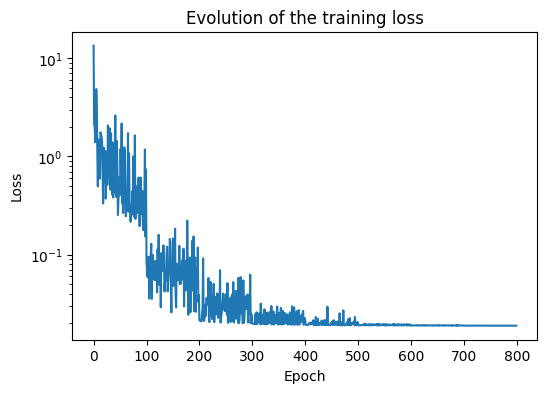

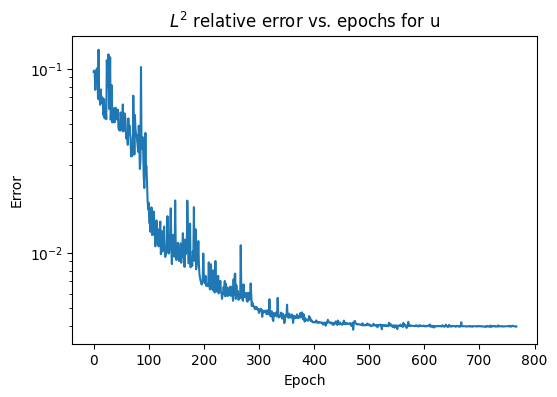

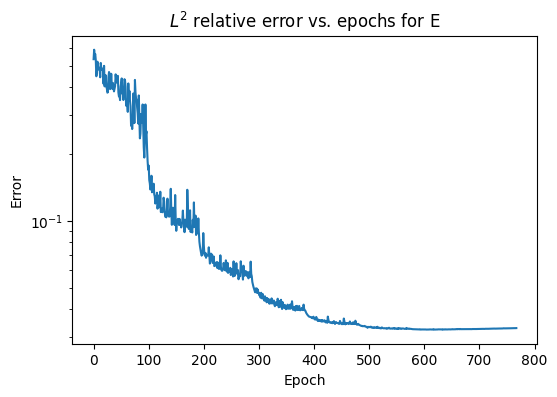

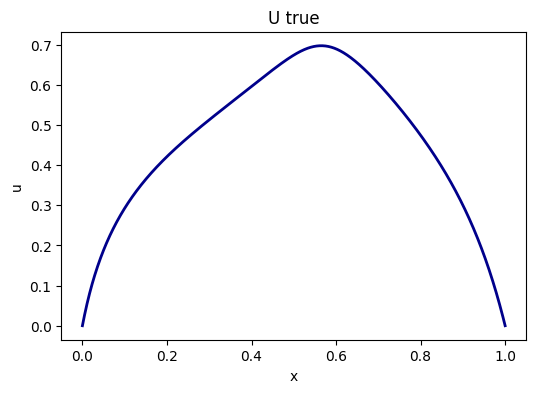

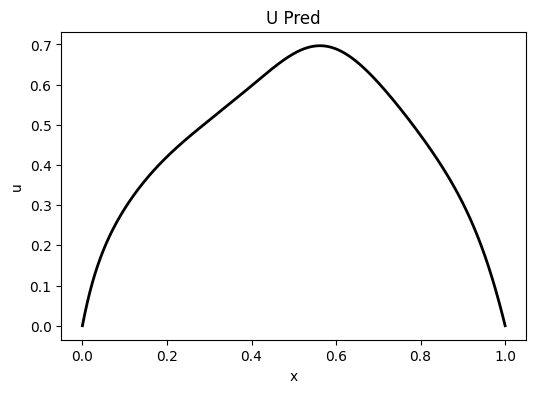

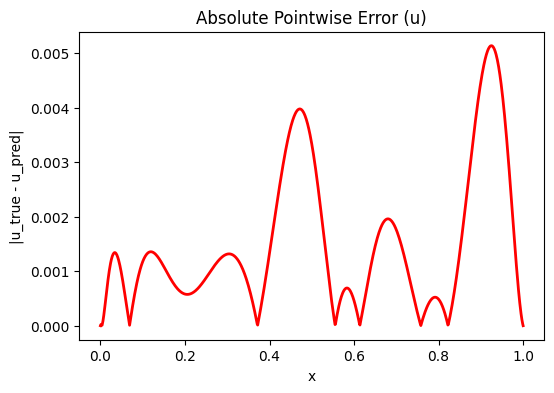

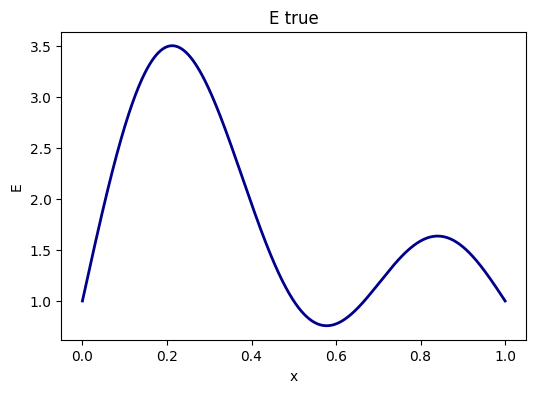

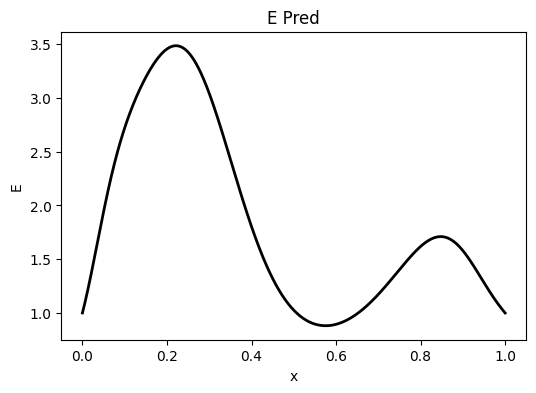

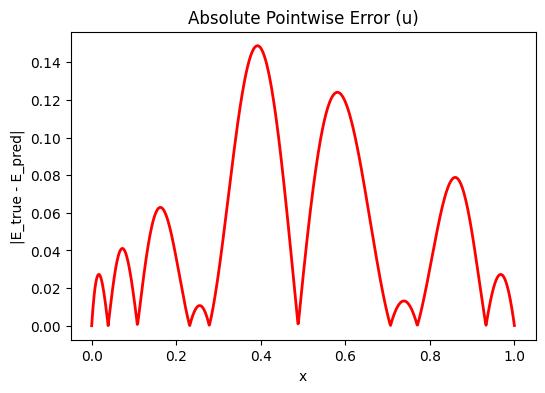

In [11]:
# loading model u trained
model_u_trained = MLP(hiperparams['u_layers']).to(device)  
model_u_trained.load_state_dict(torch.load(f'Models/best_model_A_inverse_u.pth'))

# loading model e trained
model_e_trained = MLP(hiperparams['e_layers']).to(device)  
model_e_trained.load_state_dict(torch.load(f'Models/best_model_A_inverse_e.pth'))

# ploting results
plot_results(hiperparams['nc'], model_u_trained, model_e_trained, loss_list=loss_list, error_u_list=error_u_list, error_e_list=error_e_list, save=True)